# **Proyecto 02: Clasificación Supervisada**

---

### **Integrantes**:
- Kalos Lazo
- Benjamín Soto
- Lucas Carranza
- José Osnayo

---

### **Importar librerías escenciales**

A continuación se importarán las librerías escenciales para proceder con nuestro análisis exploratorio de datos (EDA), los archivos utilizan el formato `.h5` destinado para trabajar con archivos complejos, se procederá a utilizar la librería `h5py`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py

from tsfresh import extract_features
from tsfresh.feature_extraction import MinimalFCParameters
from tsfresh.utilities.dataframe_functions import make_forecasting_frame

from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

---

### **Data**

Considerando que dentro de nuestra estructura contamos con una carpeta de datos en la localización raíz `/data`, importamos los archivos train y test para entrenamiento y testeo respectivamente.

Se procede a crear una [función](https://stackoverflow.com/questions/28170623/how-to-read-hdf5-files-in-python) para convertir de nuestros archivos de `.h5` a un pandas dataframe, de tal forma que podamos utilizar nuestros datos al aplicar el modelo. La función toma la ubicación del archivo y convierte cada dataset en un elemento del tipo numpy array, posteriormente se instancia como un objeto pandas dataframe.

Por último una vez tenemos un diccionario de dataframes, se hace esto para mantener el nombre de cada dataset para un posterior análisis y correctitud. Esto se logra al ver que al sacar las features y juntar todas las características necesitamos un mecanismo que diferencie entre las columnas.

In [2]:
def file_data_processing(path):
    with h5py.File(path, 'r') as hf:
        return {each_dataset: pd.DataFrame(hf[each_dataset][()]) for each_dataset in hf}

path = './data/'
train_path = f'{path}/train.h5'
test_path = f'{path}/test.h5'

train_data = file_data_processing(train_path)
test_data = file_data_processing(test_path)

print("Claves de columnas en train_data\n:", train_data.keys())
print("\nClaves de columnas en test_data\n:", test_data.keys())

Claves de columnas en train_data
: dict_keys(['body_acc_x', 'body_acc_y', 'body_acc_z', 'body_gyro_x', 'body_gyro_y', 'body_gyro_z', 'total_acc_x', 'total_acc_y', 'total_acc_z', 'y'])

Claves de columnas en test_data
: dict_keys(['body_acc_x', 'body_acc_y', 'body_acc_z', 'body_gyro_x', 'body_gyro_y', 'body_gyro_z', 'total_acc_x', 'total_acc_y', 'total_acc_z'])


---

### **Extracción de características**

Hasta ahora contamos con una matriz de matrices, donde en cada uno de sus hijos interiores representa un dataset del usuario para una respectiva acción con sus EEG, por ejemplo el de caminar hacia arriba, caminar hacia abajo, entre otras.

Al tener 128 características por lo que debemos inicialmente reducir la dimensionalidad, utilizaremos la reducción por LDA (Linear Discriminant Analysis), una vez logramos esto individualmente, procedemos a juntarlos todos en una matriz. Si no hicieramos esta reducción trabajaríamos con una matriz de $128 \cdot 9 = 1152$ características. 

In [3]:
def dataset_descriptive_features(df, dataset_name):
    df_conversion_long = df.copy();
    df_conversion_long['id'] = df.index;
    df_conversion_long = df_conversion_long.melt(id_vars=['id'], var_name='time', value_name='value')

    # Seleccionando parámetros a extraer
    to_extract = MinimalFCParameters()
    del to_extract["length"] # Removiendo parámetros inservibles
    
    extracted_features = extract_features(df_conversion_long, column_id = 'id', column_sort = 'time',  default_fc_parameters = to_extract, n_jobs=0)
    extracted_features.columns = [f"{dataset_name}_{each_col}" for each_col in extracted_features.columns]
    
    return extracted_features

def get_datasets_features(train_data):
    features_list = [];
    for name, df in train_data.items():
        if name != 'y':
            extracted_features = dataset_descriptive_features(df, name)
            print(f"Dimension de características extraídas en {name}: {extracted_features.shape}")
            features_list.append(extracted_features)
    return features_list;

x_train_features = get_datasets_features(train_data);
x_test_features = get_datasets_features(test_data);

Feature Extraction: 100%|██████████| 7352/7352 [00:00<00:00, 8697.84it/s]


Dimension de características extraídas en body_acc_x: (7352, 9)


Feature Extraction: 100%|██████████| 7352/7352 [00:00<00:00, 8668.16it/s]


Dimension de características extraídas en body_acc_y: (7352, 9)


Feature Extraction: 100%|██████████| 7352/7352 [00:00<00:00, 9313.98it/s]


Dimension de características extraídas en body_acc_z: (7352, 9)


Feature Extraction: 100%|██████████| 7352/7352 [00:00<00:00, 9380.98it/s]


Dimension de características extraídas en body_gyro_x: (7352, 9)


Feature Extraction: 100%|██████████| 7352/7352 [00:00<00:00, 9279.38it/s]


Dimension de características extraídas en body_gyro_y: (7352, 9)


Feature Extraction: 100%|██████████| 7352/7352 [00:00<00:00, 8562.91it/s]


Dimension de características extraídas en body_gyro_z: (7352, 9)


Feature Extraction: 100%|██████████| 7352/7352 [00:00<00:00, 9092.04it/s]


Dimension de características extraídas en total_acc_x: (7352, 9)


Feature Extraction: 100%|██████████| 7352/7352 [00:00<00:00, 8935.60it/s]


Dimension de características extraídas en total_acc_y: (7352, 9)


Feature Extraction: 100%|██████████| 7352/7352 [00:00<00:00, 9199.28it/s]


Dimension de características extraídas en total_acc_z: (7352, 9)


Feature Extraction: 100%|██████████| 2947/2947 [00:00<00:00, 9074.58it/s]


Dimension de características extraídas en body_acc_x: (2947, 9)


Feature Extraction: 100%|██████████| 2947/2947 [00:00<00:00, 8161.15it/s]


Dimension de características extraídas en body_acc_y: (2947, 9)


Feature Extraction: 100%|██████████| 2947/2947 [00:00<00:00, 9203.91it/s]


Dimension de características extraídas en body_acc_z: (2947, 9)


Feature Extraction: 100%|██████████| 2947/2947 [00:00<00:00, 9438.61it/s]


Dimension de características extraídas en body_gyro_x: (2947, 9)


Feature Extraction: 100%|██████████| 2947/2947 [00:00<00:00, 9307.59it/s]


Dimension de características extraídas en body_gyro_y: (2947, 9)


Feature Extraction: 100%|██████████| 2947/2947 [00:00<00:00, 9467.33it/s]


Dimension de características extraídas en body_gyro_z: (2947, 9)


Feature Extraction: 100%|██████████| 2947/2947 [00:00<00:00, 9297.56it/s]


Dimension de características extraídas en total_acc_x: (2947, 9)


Feature Extraction: 100%|██████████| 2947/2947 [00:00<00:00, 9459.06it/s]


Dimension de características extraídas en total_acc_y: (2947, 9)


Feature Extraction: 100%|██████████| 2947/2947 [00:00<00:00, 9426.23it/s]

Dimension de características extraídas en total_acc_z: (2947, 9)


Con la función anterior, `descriptive_features`, se logra obtener las características más importantes y descriptivas de cada dataset. Podríamos hacerlo manual obteniendo mediana, mínimo, máximo, entre otros, pero para este caso ya utilizamos funcionalidad hecha por la librería de [TsFresh](https://tsfresh.readthedocs.io/en/latest/): extrae automáticamente [características importantes](https://www.linkedin.com/pulse/unlocking-time-series-insights-tsfresh-python-guide-rany-5yr7c/) acerca de una serie temporal.

Para aplicar este método primero debe convertirse el dataframe a un formato largo (long) que es exigido por la librería, se basa en una matriz tal que cada fila es una observación y cada columna un momento del tiempo, posteriormente ese train data sera dividido para el eje X, Y. El resultado esperado en `x_train_features` es almacenar una lista con las features más importantes obtenidas de cada dataset.

In [4]:
X_train = pd.concat(x_train_features, axis = 1).dropna(axis = 1).reset_index(drop = True)
Y_train = pd.DataFrame(train_data['y'].to_numpy().flatten())

X_test = pd.concat(x_test_features, axis=1).dropna(axis=1).reset_index(drop=True)

print(f"Dimensiones de X_train: {X_train.shape}")
print(f"Dimensiones de Y_train: {Y_train.shape}")
print(f"Dimensiones de X_test: {X_test.shape}")

Dimensiones de X_train: (7352, 81)
Dimensiones de Y_train: (7352, 1)
Dimensiones de X_test: (2947, 81)


Una vez realizado este proceso contaremos con nuevas columnas en nuestro `X_train`, pues hemos aplicado una funcionalidad de la librería TsFresh y hemos escarbado la información más importante de nuestra serie de tiempo (*time series*). Cabe resaltar que `X_train` está concatenando múltiples Dataframes en uno solo: `x_train_features`, la opción `axis = 1` indica que será por medio de las columnas, se eliminan las columnas con valores `NaN` y se elimina el indice anterior. En el caso de Y sólo se convierte en vector unidimensional con `flatten`.

In [5]:
X_train.keys()

Index(['body_acc_x_value__sum_values', 'body_acc_x_value__median',
       'body_acc_x_value__mean', 'body_acc_x_value__standard_deviation',
       'body_acc_x_value__variance', 'body_acc_x_value__root_mean_square',
       'body_acc_x_value__maximum', 'body_acc_x_value__absolute_maximum',
       'body_acc_x_value__minimum', 'body_acc_y_value__sum_values',
       'body_acc_y_value__median', 'body_acc_y_value__mean',
       'body_acc_y_value__standard_deviation', 'body_acc_y_value__variance',
       'body_acc_y_value__root_mean_square', 'body_acc_y_value__maximum',
       'body_acc_y_value__absolute_maximum', 'body_acc_y_value__minimum',
       'body_acc_z_value__sum_values', 'body_acc_z_value__median',
       'body_acc_z_value__mean', 'body_acc_z_value__standard_deviation',
       'body_acc_z_value__variance', 'body_acc_z_value__root_mean_square',
       'body_acc_z_value__maximum', 'body_acc_z_value__absolute_maximum',
       'body_acc_z_value__minimum', 'body_gyro_x_value__sum_values',

En este caso podemos ver cómo reducimos la complejidad ahora con $90$ columnas de las cuales tenemos la información escencial de las líneas de tiempo, que anteriormente eran $128 \cdot 9$. Con esta información nuestro modelo ya puede empezar a ser entrenado. Se verifica posteriormente que se preservan las filas iniciales, en este caso $7352$.

In [6]:
X_train.head()

,body_acc_x_value__sum_values,body_acc_x_value__median,body_acc_x_value__mean,body_acc_x_value__standard_deviation,body_acc_x_value__variance,body_acc_x_value__root_mean_square,body_acc_x_value__maximum,body_acc_x_value__absolute_maximum,body_acc_x_value__minimum,body_acc_y_value__sum_values,...,total_acc_y_value__minimum,total_acc_z_value__sum_values,total_acc_z_value__median,total_acc_z_value__mean,total_acc_z_value__standard_deviation,total_acc_z_value__variance,total_acc_z_value__root_mean_square,total_acc_z_value__maximum,total_acc_z_value__absolute_maximum,total_acc_z_value__minimum
0,0.290392,0.002025,0.002269,0.002941,0.000009,0.003714,0.010810,0.010810,-0.004294,-0.211888,...,-0.132631,12.765670,0.099841,0.099732,0.003970,0.000016,0.099811,0.109485,0.109485,0.088742
1,0.022239,0.000110,0.000174,0.001981,0.000004,0.001989,0.005251,0.006706,-0.006706,0.048848,...,-0.132631,12.408253,0.097748,0.096939,0.004918,0.000024,0.097064,0.105788,0.105788,0.081100
2,0.054796,0.000627,0.000428,0.002908,0.000008,0.002940,0.008167,0.010483,-0.010483,-0.156364,...,-0.137142,11.890790,0.093636,0.092897,0.006145,0.000038,0.093100,0.105788,0.105788,0.081100
3,0.042157,0.000269,0.000329,0.002678,0.000007,0.002698,0.008167,0.010483,-0.010483,-0.608434,...,-0.143545,11.219701,0.087501,0.087654,0.004945,0.000024,0.087793,0.098737,0.098737,0.076888
4,-0.024980,-0.000144,-0.000195,0.002015,0.000004,0.002025,0.005650,0.006847,-0.006847,0.038168,...,-0.143545,10.879856,0.084765,0.084999,0.003637,0.000013,0.085077,0.093388,0.093388,0.074595


---
### **Exploración de Datos**

Lo primero que queremos es conocer nuestras features que previamente han sido modificados, es así que como primer paso podemos usar la función `describe()` que permite de manera sencilla obtener estadísticas descriptivas de nuestras columnas.

In [7]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
body_acc_x_value__sum_values,7352.0,-0.081447,1.853377,-33.700321,-0.385138,-0.010087,0.287138,19.056348
body_acc_x_value__median,7352.0,-0.024342,0.044907,-0.285125,-0.038399,-0.001441,0.000300,0.151517
body_acc_x_value__mean,7352.0,-0.000636,0.014480,-0.263284,-0.003009,-0.000079,0.002243,0.148878
body_acc_x_value__standard_deviation,7352.0,0.129105,0.145224,0.001413,0.003758,0.018826,0.246462,0.648675
body_acc_x_value__variance,7352.0,0.037755,0.054605,0.000002,0.000014,0.000354,0.060744,0.420780
...,...,...,...,...,...,...,...,...
total_acc_z_value__variance,7352.0,0.010558,0.015461,0.000009,0.000033,0.000413,0.017381,0.127318
total_acc_z_value__root_mean_square,7352.0,0.285424,0.232424,0.003700,0.125216,0.202054,0.374049,0.988379
total_acc_z_value__maximum,7352.0,0.245178,0.306718,-0.978027,0.042551,0.213361,0.420355,1.281363
total_acc_z_value__absolute_maximum,7352.0,0.448607,0.289168,0.007652,0.226644,0.402390,0.644768,1.639609


Antes de mostrar gráficamente estos datos, vamos a utilizar la información de `Y` que está numérica desde el `1 \to 6` que indica la acción, por ejemplo "WALKING", por ello vamos a utilizar estos labels considerando el orden lógico propuesto en el enunciado.

In [8]:
Y_train[0].unique()

array([5., 4., 6., 1., 3., 2.])

Hemos creado una función para asignar cada elemento de `Y_train` a el obtenido dentro de sus filas, de esta forma contamos las apariciones y es posible gráficamente comparar y notar que `LAYING: 5`, es el que más apareció dentro de los registros de entrenamiento. Otra cosa a mencionar es que las actividades con su etiqueta asociada están distribuidas de manera equitativa.

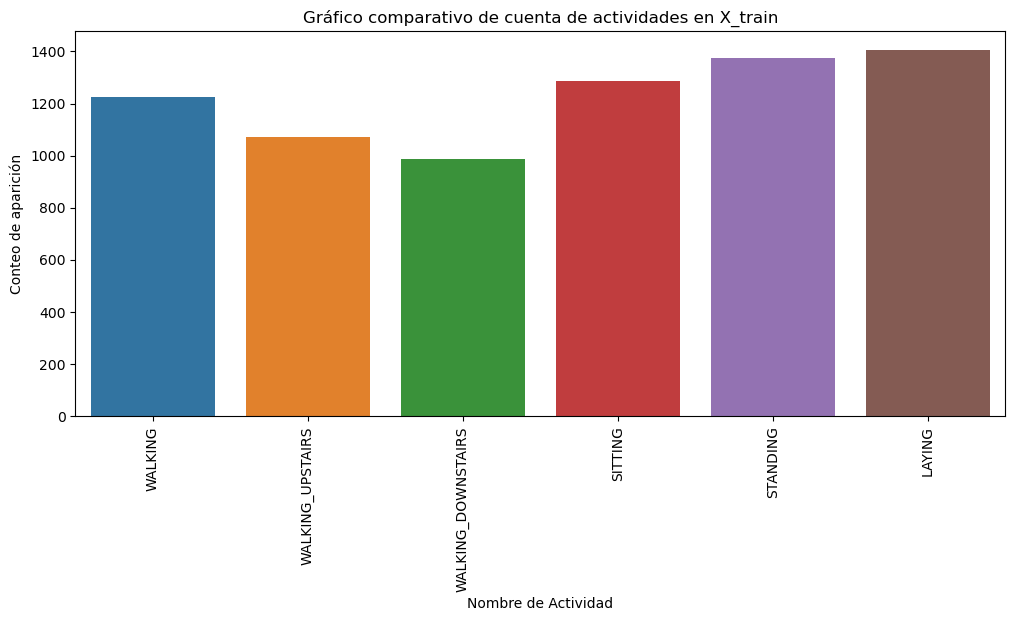

In [9]:
def assign_key_labels(df, arr_to_mapped):
    activities_map = {i+1: arr_to_mapped[i] for i in range(len(arr_to_mapped))}
    activities_mapped = df[0].map(activities_map)
    df_mapped = pd.DataFrame({'Activity': activities_mapped})
    
    return df_mapped
    
labels_actions = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
Y_train_label = assign_key_labels(Y_train, labels_actions)


plt.figure(figsize=(12,5))
sns.countplot(x='Activity', data=Y_train_label, order=labels_actions)
plt.xticks(rotation='vertical')
plt.title('Gráfico comparativo de cuenta de actividades en X_train')
plt.xlabel('Nombre de Actividad')
plt.ylabel('Conteo de aparición')
plt.show()

---

### **Procesamiento de datos**

Ahora, se procede con la división de los conjuntos de datos, usando la función train_test_split() de la librería sklearn.model_selection, obtenemos los valores de entrenamiento y validación.

No obstante se proceden a escalar los datos, tanto de entranemiento como de validación, esto es necesario para el modelo seleccionado de K-NN, se logra usando StandardScaler() de la librería sklearn.preprocessing.

In [10]:
X_train_split, X_val, Y_train_split, Y_val = train_test_split(X_train, Y_train, test_size = 0.3, random_state = 737)
scaler = StandardScaler()

X_train_split = scaler.fit_transform(X_train_split)
X_val = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


## Modelos de Clasificación

### **Modelo 1: K-NN**

In [16]:
import math
from collections import Counter
import numpy as np


def parent(i):
    return ((i+1)//2) - 1

def left(i):
    return 2*i + 1

def right(i):
    return 2*i + 2



class Heap:
    def __init__(self):
        self.heap_size = 0
        self.A = []

    def max_heapify(self, i):
        l = left(i)
        r = right(i)
        largest = i

        if l < self.heap_size and self.A[l] > self.A[largest]:
            largest = l

        if r < self.heap_size and self.A[r] > self.A[largest]:
            largest = r

        if largest != i:
            temp = self.A[largest]
            self.A[largest] = self.A[i]
            self.A[i] = temp
            self.max_heapify(largest)

    def push(self , el):
        if self.heap_size == 0:
            if len(self.A) == self.heap_size:
                self.A.append(el)
            else:
                self.A[self.heap_size] = el
            self.heap_size += 1
        else:
            if len(self.A) == self.heap_size:
                self.A.append(el)
            else:
                self.A[self.heap_size] = el
            self.heap_size += 1
            i = self.heap_size - 1
            while i > 0 and self.A[parent(i)] < self.A[i]:
                temp = self.A[i]
                self.A[i] = self.A[parent(i)]
                self.A[parent(i)] = temp
                i = parent(i)

    def max_key(self):
            return self.A[0]

    def pop(self):
        maximum = self.A[0]
        self.A[0] = self.A[self.heap_size - 1]
        self.heap_size -= 1
        self.max_heapify(0)
        return maximum

    def arr(self):
        return self.A[0:self.heap_size]

    def size(self):
        return self.heap_size



def distance(p1, p2):
    return np.linalg.norm(p1 - p2, 2)


class KdNode:

    def __init__(self, point, label, idx_column):
        self.point = point
        self.idx_column = idx_column
        self.label = label
        self.left = None
        self.right = None

    def show(self):
        print(self.point)
        print(self.label)



class KdTree:
    def __init__(self, data_points):
        self.data_points = data_points
        self.root = self._build_tree(data_points=data_points, depth=0)

    def _build_tree(self, data_points, depth):
        """
            Construct a KdTree with a set of data points.
        :param data_points: a dataframe containing data points.
        :param depth: actual depth of the tree.
        :return: A KdNode object.
        """
        if len(data_points) == 0:
            return None

        # se selecciona la columna, en base a la pronfundidad actual, pero se excluye
        # la última columna que contiene los labels
        idx_column = depth % (data_points.shape[1] - 1)

        # se ordena en base a la columna seleccionada.
        data_points_sorted = data_points[np.argsort(data_points[:, idx_column])]
    
        
        # se separa la data en base a la mediana m
        n = len(data_points_sorted)
        m = n // 2
        label_m = data_points_sorted[m, -1]
        point = data_points_sorted[m, :-1]
        data_left = data_points_sorted[:m]
        data_right = data_points_sorted[m+1:]

        # se crean el nodo raiz y sus hijos.
        node = KdNode(point=point , label=label_m, idx_column=idx_column)
        node.left = self._build_tree(data_left, depth+1)
        node.right = self._build_tree(data_right, depth+1)

        # retorna la raiz
        return node

    def knn_search(self,node,  point, k , max_heap):
        """
            Store the k nearest neighbors of the point in the max_heap.
        :param node: The root of the subtree where finds the k nearest neighbors.
        :param point: The point to classificate.
        :param k: The number of nearest neighbors
        :param max_heap: max_heap where store the k nearest neighbor
        :return: A KdNode object.
        """

        #base case
        if node is None:
            return

        #the split column of the node 
        axis = node.idx_column
        
        #dist of node with the point
        current_dist = distance(point, node.point)

        # push if heap doesn't have k elements yet
        if max_heap.size() < k:
            max_heap.push( (current_dist , node))
        
        # if the heap has k elements, replace if the node is better than the away node
        elif current_dist < max_heap.max_key()[0]:
            max_heap.pop()
            max_heap.push( (current_dist , node))

        #select the closest node 
        if point[axis] < node.point[axis] :
            close_node = node.left
            away_node = node.right
        else:
            close_node = node.right
            away_node = node.left

        # search in the closset node
        self.knn_search(close_node, point, k, max_heap)

        # search in the away node if its possible to find a best candidate, is its inpossible skip it
        if max_heap.size() < k or abs(point[axis] - node.point[axis]) < max_heap.max_key()[0]:
            self.knn_search(away_node, point, k, max_heap)


    def knn(self , point, k):
        max_heap = Heap()
        self.knn_search(self.root, point, k, max_heap)

        labels = []
        for neighbor in max_heap.arr():
            labels.append(neighbor[1].label)

        cont = Counter(labels)

        label, _ = cont.most_common(1)[0]

        return label


    def predict(self, x , k):
      return [self.knn(row , k) for row in x]

    def print_root(self):
      self.root.show()


def norm_data(data):
    min_val = np.min(data, axis=0)
    max_val = np.max(data, axis=0)
    data = (data - min_val) / (max_val - min_val)
    return data

In [15]:
X_train_norm = norm_data(X_train_split)
X_val_norm = norm_data(X_val)

data_points_train = np.hstack((X_train_norm, Y_train_split.to_numpy().reshape(-1, 1)))
kdtree = KdTree(data_points_train)

Y_pred_knn = kdtree.predict(X_val_norm , 5)


# - PRECISIÓN
accuracy_val = accuracy_score(Y_val, Y_pred_knn)
print(f"Precisión en el conjunto de validación: {accuracy_val * 100:.2f}%")

# - CLASIFICACION
print(classification_report(Y_val, Y_pred_knn, target_names=labels_actions))


Precisión en el conjunto de validación: 96.55%
                    precision    recall  f1-score   support

           WALKING       0.98      0.97      0.97       366
  WALKING_UPSTAIRS       0.97      0.95      0.96       305
WALKING_DOWNSTAIRS       0.97      0.99      0.98       301
           SITTING       0.94      0.93      0.94       369
          STANDING       0.94      0.95      0.95       437
            LAYING       1.00      1.00      1.00       428

          accuracy                           0.97      2206
         macro avg       0.97      0.97      0.97      2206
      weighted avg       0.97      0.97      0.97      2206



### **Modelo 2 (opcional): Decision Tree**

El modelo de clasificación decision tree consiste en un algoritmo recursivo para clasificar datos a través de un árbol. El procedimiento se trata de dividir los datos de la forma más eficiente usando un criterio de clasificación, hasta llegar a un punto donde cada grupo contenga solo un tipo de etiqueta en los llamados nodos hoja o terminales.

Para implementarlo se crean las clases nodo, split y DT(decision tree). La clase nodo define la estructura de los grupos y específicamente el nodo terminal. La clase split contiene las funciones de clasificación y se usa en el desicion tree como los nodos no terminales. La clase DT define el modelo, donde se puede elegir el criterio de clasificación ya sea por entropía o GINI, también se le pueden agregar límites a la altura del árbol y al tamaño de los grupos, contiene el algoritmo recursivo del desicion tree usando dentro las clases nodo y split.

La idea es que se construya el árbol de desición con su raíz apuntando al atributo raíz del DT, para que al ingresar los datos de validación y testing, estos recorran el árbol de forma eficiente hasta llegar a su respectivo nodo terminal.

In [11]:
MAX_DEPTH = 10
MIN_SAMPLE = 3
NINF = -float("inf")

def entropy(y):
    n = len(y)
    _, counts = np.unique(y, return_counts=True)
    p = counts / n
    h = -np.sum(p * np.log2(p))
    return h

def gini(y):
    n = len(y)
    _, counts = np.unique(y, return_counts=True)
    p = counts / n
    gini = 1 - np.sum(p**2)
    return gini

def get_info(parent_y, left_y, right_y, method="e"):
    peso_l = len(left_y) / len(parent_y)
    peso_r = len(right_y) / len(parent_y)
    
    if method == "e":
        return entropy(parent_y) - (peso_l*entropy(left_y) + peso_r*entropy(right_y)) 
    else:
        return gini(parent_y) - (peso_l*gini(left_y) + peso_r*gini(right_y))

# Nodo Decision o Nodo Hoja
class Nodo:
    def __init__(self, index=None, left=None, right=None, info=None, umbral=None):
        self.index = index
        self.left = left
        self.right = right
        self.info = info
        self.umbral = umbral

        self.leaf = False
        self.valor = None
    
    def make_leaf(self, y):
        y = list(y)
        self.valor = max(y, key=y.count)
        self.leaf = True
    
# Clase para almacenar la informacion de un split
class Split:
    def __init__(self, index=None, left=None, right=None, info=NINF, umbral=None):
        self.index = index
        self.left = left
        self.right = right
        self.info = info
        self.umbral = umbral
    
    def update(self, new_index, new_left, new_right, new_info, new_umbral):
        if new_info > self.info:
            self.index = new_index
            self.left = new_left
            self.right = new_right
            self.info = new_info
            self.umbral = new_umbral

    def to_node(self, left, right):
        return Nodo(index=self.index, left=left, right=right, info=self.info, umbral=self.umbral)
    
# Arbol de Decision
class DT:
    def __init__(self, X, Y, max_depth=MAX_DEPTH, min_sample=MIN_SAMPLE, method="g"):
        self._max_depth = max_depth
        self._min_sample = min_sample
        self._method = method
        self.root = self.build(np.concatenate((X, Y), axis=1))
    
    def build(self, data, depth=0):
        # print(f"node at depth: {depth}")
        X, Y = data[:, 0:-1], data[:, -1]
        n, k = X.shape

        if depth >= self._max_depth or n < self._min_sample:
            return self._create_leaf(Y)

        best_split = self.get_best_split(data, n, k)

        if best_split.info <= 0:
            return self._create_leaf(Y)

        left_tree = self.build(best_split.left, depth + 1)
        right_tree = self.build(best_split.right, depth + 1)
        return best_split.to_node(left_tree, right_tree)
    
    def get_best_split(self, data, n, k): # n: numero de filas, k: numero de columnas
        best_split = Split()

        # optimizacion tomando un subset de features para los umbrales
        features_subset = np.random.choice(range(k), int(np.sqrt(k)*1.5), replace=False)

        for char_index in features_subset:
            unique_values = np.unique(data[:, char_index])

            for i in range(1, len(unique_values)):
                umbral = (unique_values[i - 1] + unique_values[i]) / 2
                data_left = data[data[:, char_index] <= umbral]
                data_right = data[data[:, char_index] > umbral]

                if len(data_left) == 0 or len(data_right) == 0:
                    continue

                parent_y, left_y, right_y = data[:, -1], data_left[:, -1], data_right[:, -1]
                info = get_info(parent_y, left_y, right_y, method=self._method)

                if info > best_split.info:
                    best_split.index = char_index
                    best_split.left = data_left
                    best_split.right = data_right
                    best_split.info = info
                    best_split.umbral = umbral

        return best_split
    
    def predict(self, X):
        y_pred = [self._predict_recursive(self.root, fila) for fila in X]
        return np.array(y_pred) 

    def _predict_recursive(self, nodo, x):
        if nodo.leaf:
            return nodo.valor

        # decidir el hijo por el cual seguir en el nodo decision
        if x[nodo.index] <= nodo.umbral:
            return self._predict_recursive(nodo.left, x)
        else:
            return self._predict_recursive(nodo.right, x)

    def _create_leaf(self, Y):
        leaf = Nodo()
        leaf.make_leaf(Y)
        return leaf
    
    
    '''
    Ejemplo de uso:
    X = x_train
    Y = y_train.reshape(-1, 1)
    model = DT(X, Y) // DT(X, Y, max_depth=20, min_sample=5, method="e")
    y_pred = model.predict(x_test)
    '''

In [12]:
dt = DT(X_train_split, Y_train_split.to_numpy().reshape(-1, 1), max_depth=15, method='g')
Y_pred_tree = dt.predict(X_val)
# - PRECISIÓN
accuracy_val_tree = accuracy_score(Y_val, Y_pred_tree)
print(f"Precisión en el conjunto de validación: {accuracy_val_tree * 100:.2f}%")

# - CLASIFICACIÓN
print(classification_report(Y_val, Y_pred_tree, target_names=labels_actions))

# - MATRIZ DE CONFUSIÓN
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(Y_val, Y_pred_tree), annot=True, fmt='g', cbar=False)
plt.xlabel('Prediccion')
plt.ylabel('Valor real')
plt.title('Matriz de Confusion - DT')
plt.show()

---
### **Modelo 03: Regresión logística multivariada**

Para poder implementar correctamente la regresión logística que se tenía (desarrollada en laboratorios) se tuvo que modificar ciertos aspectos, dado que ahora contamos con labels del 1 al 6, es decir ya no podemos usar una clasificación binaria, si no una que involucre multivariables.

El primer cambio realizado fue utilizar una **función softmax** definida como `softmax`, en lugar de una sigmoide `s`. Esto se debe a que según nuestra [investigación](https://stats.stackexchange.com/questions/233658/softmax-vs-sigmoid-function-in-logistic-classifier) notamos que la función sigmoide está restringida a una clasificación logística binaria: 2 clases, mientras que la softmax permite una clasificación de múltiples clases. Matemáticamente, este método sólo extiende la fórmula de regresión logística para $k$ clases.

Para el caso de la función pérdida, apartado donde se mide el error de la predicción de clases se actualizó de binary cross entropy a cross entropy con una regularización L2 (ridge) para manejar múltiples clases, la regularización elegida tiene como objetivo penalizar grandes valores y así evitar el overfitting. Se ejecuta softmax a la hora de predecir y busca entre todas las clases de predicción la que tenga mayor probabilidad.

Por otro lado, para poder utilizar las etiquetas que se indicaron en el problema, primero obtenemos los valores únicos para el eje Y, una vez los tenemos, debemos de usar un formato para entrenar las multiclases, por lo que es necesario contar con una matriz de tamaño $n x k$, siendo $n$ la cantidad de filas de $Y$, mientras que $k$ la cantidad de clases. Se traza una diagonal de $1$ para la correspondiente categoría indicando su importancia. Es decir se transforman las variables en vectores binarios $(1, 0)$ para usarse en la función pérdida.

In [ ]:
def one_hot_encode(y, num_classes):
    y = y.astype(int) - 1;
    
    encoded_matrix = np.zeros((y.shape[0], num_classes))
    encoded_matrix[np.arange(y.shape[0]), y] = 1
    return encoded_matrix

class MultivariateLogisticRegression():
    def __init__(self, alpha=0.01, epochs=10000, epsilon=0.00001, reg_ridge=0.001):
        self.alpha = alpha
        self.epochs = epochs
        self.epsilon = epsilon
        self.reg_ridge = reg_ridge
        self.weights = None

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def loss(self, y, y_approx):
        n = len(y)
        y_approx = np.clip(y_approx, self.epsilon, 1 - self.epsilon)
        L = -np.sum(y * np.log(y_approx)) / n
        L += self.reg_ridge * np.sum(self.weights**2) / (2 * n)
        
        return L

    def derivatives(self, x, y):
        y_approx = self.softmax(np.dot(x, self.weights))
        dw = np.dot(x.T, (y_approx - y)) / len(y)
        dw += self.reg_ridge * self.weights / len(y)
        
        return dw

    def update_parameters(self, derivatives):
        self.weights -= self.alpha * derivatives

    def train(self, x, y):
        np.random.seed(11)
        self.weights = np.random.rand(x.shape[1], y.shape[1])
        loss_vec = []

        for epoch in range(self.epochs):
            y_approx = self.softmax(np.dot(x, self.weights))
            loss_value = self.loss(y, y_approx)
            dw = self.derivatives(x, y)
            self.update_parameters(dw)
            loss_vec.append(loss_value)
            if epoch % 1000 == 0:
                print(f'Número de epoch #{epoch}, Valor de pérdida: {loss_value}')

        return loss_vec

    def predict(self, x):
        probabilities = self.softmax(np.dot(x, self.weights))
        
        return np.argmax(probabilities, axis=1)

Se procede a hacer la normalización de datos por medio de `StandardScaler()`. Además se preparan los datos, es decir por medio de la función softmax que recibe un vector $[1, 0, 0, \dots , 0]$, y lo convierte a un vector de probabilidades donde $s = [s_1, s_2, \dots, s_k]$ es la salida, tal que la suma de todas las clases es $1$, indicando la probabilidad de que una muestra pertenezca a cada una de las clases posibles, recordando que por el enconding las columnas indican las clases denotadas como $k$.

$$
softmax(s_i) = \frac{e^{s_i}}{\sum_j^c e^{s_j}}
$$

Es así que con softmax logramos tener un vector de probabilidades que nos va servir para interpretar la probabilidad de que una muestra pertenezca a una clase específica. Su implementación en [python](https://stackoverflow.com/questions/34968722/how-to-implement-the-softmax-function-in-python) se realiza con el cálculo de exponenciales dividido entre su suma para convertir en decimales que indiquen probabilidad, osea suma de $1$.

In [ ]:
# tecnica de división de datos en entrenamiento y validación
labels_actions = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_split_scaled = scaler.fit_transform(X_train_split)
X_val_split_scaled = scaler.transform(X_val_split)
X_test_scaled = scaler.transform(X_test)

num_classes = len(np.unique(y_train_split))
Y_train_encoded = one_hot_encode(y_train_split.to_numpy().flatten().astype(int), num_classes)

model = MultivariateLogisticRegression(alpha=0.2, epochs=10000, reg_ridge=0.1)
loss_vec = model.train(X_train_split_scaled, Y_train_encoded)

# se suma 1 a la prediccion por notacion de kaggle
y_pred = model.predict(X_val_split_scaled) + 1
accuracy = accuracy_score(y_val_split, y_pred)

y_val_pred = model.predict(X_val_split_scaled) + 1
accuracy = accuracy_score(y_val_split, y_val_pred)

print(classification_report(y_val_split, y_val_pred, target_names=labels_actions))
print(f'Exactitud del modelo en validación: {accuracy * 100:.2f}%')

y_test_pred = model.predict(X_test_scaled) + 1

c:\Users\jjosn\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

## Training

### Split

### Resultados

## Submission

In [ ]:
X_test_norm = norm_data(X_test.to_numpy())

# Y_test_knn = kdtree.predict(X_test_norm)
Y_test_knn = np.array(Y_test_knn)
print(Y_test_knn.shape)
print(np.unique(Y_test_knn))

# Y_test_tree = dt.predict(X_test.to_numpy())
# print(Y_test_tree.shape)
# print(np.unique(Y_test_tree))

In [ ]:
# Escribiendo a csv
output = "results.csv"

result_csv = pd.DataFrame(Y_test_knn.astype(int))
# result_csv = pd.DataFrame(Y_test_tree.astype(int))
result_csv.head()
result_csv = result_csv.reset_index()
result_csv['index'] += 1

result_csv.rename(columns={'index': 'ID', 0: 'y'}, inplace=True)
result_csv.to_csv(output, index=False)
print(f"Wrote to: {output} !")